# Импорт библиотек

In [1]:
from subprocess import check_output
from tqdm import tqdm_notebook
import numpy as np
import os
from skimage import io, transform, filters
from numba import jit
import warnings
import shutil
import zipfile
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Загрузка изображений с Google Диска

In [ ]:
zip_file = '/content/drive/My Drive/test_img.zip'  
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
zip_file = '/content/drive/My Drive/train_img.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

# Создание изображений в оттенках серого

## Маска фона

In [2]:
@jit(nopython=True)
def get_background(im_arr, t):
    h, w = im_arr.shape[:2]
    background_mask = np.zeros(im_arr.shape, np.int8)
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = im_arr[i:i+8, j:j+8]
            if (np.std(block) < t) & (np.mean(block) < 200) & (np.mean(block) > 2):
                background_mask[i:i+8, j:j+8] = 1
    return background_mask

## Вычисление фона

In [3]:
@jit(nopython=True)
def get_background_colour(background_image):
    background_colour = np.zeros((background_image.shape[0]//50, background_image.shape[1]//50), np.float32)
    h, w = background_image.shape
    for i in range(0, h//50):
        for j in range(0, w//50):
            curr_slice = background_image[i*50:(i+1)*50, j*50:(j+1)*50]
            nan_sum = np.sum(np.isnan(curr_slice))
            if nan_sum < 50 * 50:
                background_colour[i, j] = np.nanmean(curr_slice)
    return background_colour

## Устранение бликов

In [4]:
def correct(im_arr, t):
    grad1, grad2 = np.gradient(im_arr)
    missing = grad1 + grad2 + im_arr == 0
    background_mask = get_background(im_arr, t).astype(bool)
    background_image = np.where(background_mask, im_arr, np.nan)
    background_colour = get_background_colour(background_image)
    background_colour = np.repeat(np.repeat(background_colour, 50, 0), 50, 1)
    background_colour = filters.gaussian(background_colour, sigma=40, preserve_range=True)
    im_arr_out =  (im_arr - background_colour) / (255 - background_colour)
    im_arr_out = np.maximum(0, im_arr_out)
    im_arr_out[missing] = 0.5
    return im_arr_out

## Применение преобразований

In [5]:
def process_one_image(path):
    im = io.imread(path)
    im = np.mean(im, 2)
    im1 = correct(im, 4)
    return im1.astype(np.float32)

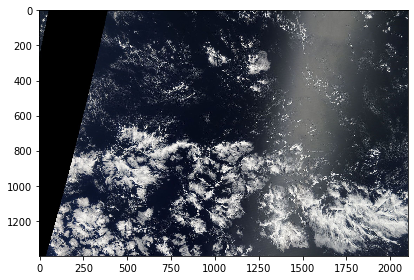

In [8]:
io.imshow(f'content/test_img/test_images/0202748.jpg')

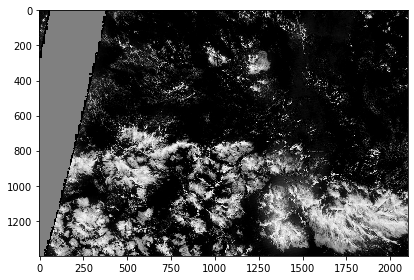

In [10]:
io.imshow(process_one_image(f'content/test_img/test_images/0202748.jpg'))

In [ ]:
files = os.listdir('/content/train_img/train_images')
for fname in tqdm_notebook(files, total=len(files)):
    io.imsave(f'/content/train_img/grayscale/{fname}', process_one_image(f'/content/train_img/train_images/{fname}')) 

In [ ]:
files = os.listdir('/content/test_img/test_images')
for fname in tqdm_notebook(files, total=len(files)):
    io.imsave(f'/content/test_img/grayscale/{fname}',process_one_image(f'/content/test_img/test_images/{fname}')) 

## Сохранение полученных изображений в архив

In [ ]:
shutil.make_archive('train_grayscale', 'zip', '/content/train_img/grayscale')

In [ ]:
shutil.make_archive('test_grayscale', 'zip', '/content/test_img/grayscale')